In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
!unzip "drive/My Drive/star_wars.zip" 

In [3]:
import numpy as np
import torch
import os
import cv2
from tqdm.notebook import tqdm
from torch.utils.data import Dataset, DataLoader
from torchvision.models import resnet34
from google.colab import auth
from googleapiclient.discovery import build
from torchvision import transforms
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score
from matplotlib import pyplot as plt
from skimage import color
import random

In [4]:
file_names = []
file_labels = []
for idx, class_dir in enumerate(os.listdir("star_wars")):
  print(f"taking files from the folder \"{class_dir}\" and give them a class {idx}")
  
  # Do not take files other than .jpg .jpeg и .png
  for file in os.listdir(os.path.join("star_wars", class_dir)):
    if not file.endswith(('.jpg', '.jpeg', '.png')):
      continue
      
    file_names.append(os.path.join("star_wars", class_dir, file))
    file_labels.append(idx)

taking files from the folder "chewbacca" and give them a class 0
taking files from the folder "luke_skywalker" and give them a class 1
taking files from the folder "darth_vader" and give them a class 2
taking files from the folder "princess_leia" and give them a class 3


3


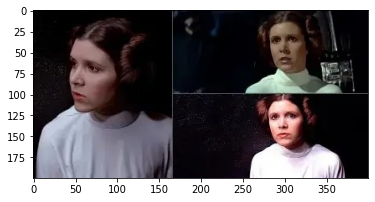

In [5]:
# Check random image
random_index = np.random.choice(range(len(file_names)))
test_img = cv2.imread(file_names[random_index])
test_img = cv2.cvtColor(test_img, cv2.COLOR_BGR2RGB)
print(file_labels[random_index])
plt.imshow(test_img)

(200, 400, 3)

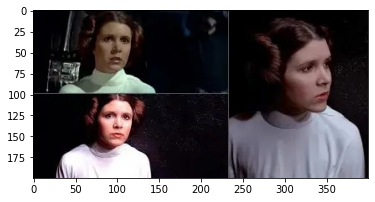

In [6]:
# Flip image
horizontal_flip_img = cv2.flip(test_img, 1)
plt.imshow(horizontal_flip_img)
horizontal_flip_img.shape

(200, 400, 3)

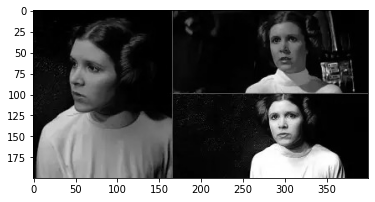

In [7]:
# Grayscale image
test_img_gray = cv2.cvtColor(test_img, cv2.COLOR_RGB2GRAY)

gray_img = np.zeros_like(test_img)
gray_img[:,:,0] = test_img_gray
gray_img[:,:,1] = test_img_gray
gray_img[:,:,2] = test_img_gray

plt.imshow(gray_img)
test_img.shape

In [8]:
# Splitting into Train and Test
train_file_names, test_file_names, train_file_labels, test_file_labels = train_test_split(file_names, file_labels, test_size = 0.3, train_size = 0.7)

print(len(file_names), len(file_labels))
len(train_file_names), len(train_file_labels), len(test_file_names), len(test_file_labels)

4434 4434


(3103, 3103, 1331, 1331)

In [9]:
def add_pad(img, shape):
    color_pick = img[0][0]
    padded_img = color_pick * np.ones(shape + img.shape[2:3], dtype=np.uint8)
    x_offset = int((padded_img.shape[0] - img.shape[0]) / 2)
    y_offset = int((padded_img.shape[1] - img.shape[1]) / 2)
    padded_img[x_offset:x_offset + img.shape[0], y_offset:y_offset + img.shape[1]] = img

    return padded_img


def resize(img, shape):
    scale = min(shape[0] * 1.0 / img.shape[0], shape[1] * 1.0 / img.shape[1])
    if scale != 1:
        img = cv2.resize(img, dsize=None, fx=scale, fy=scale, interpolation=cv2.INTER_LINEAR)
    return img   

In [10]:
# Dataset with augmentation. 
class StarWarsDataset_aug(Dataset):
    def __init__(self, filenames, labels):
        self.filenames = filenames
        self.labels = labels

    def __len__(self):
        return len(self.filenames)

    def __getitem__(self, idx, p=15):
        filename = self.filenames[idx]
        label = self.labels[idx]
        
        if random.randint(1,100) < p:
            img = cv2.imread(filename)
            gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
        
            img = np.zeros_like(img)
            img[:,:,0] = gray
            img[:,:,1] = gray
            img[:,:,2] = gray
        else:
            img = cv2.imread(filename)
            img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)

        if random.randint(1,100) < 5:
            img = cv2.GaussianBlur(img, (15, 15), 0)

        if random.randint(1,100) < p:
            img = cv2.flip(img, 1)
         
        img = resize(img, (224, 224))
        img = add_pad(img, (224, 224))
        
        img = torch.tensor(img, dtype=torch.float).permute(2, 0, 1) / 255.

        return img, label

In [11]:
 # Dataset without augmentation. 
 class StarWarsDataset(Dataset):
    def __init__(self, filenames, labels):
        self.filenames = filenames
        self.labels = labels

    def __len__(self):
        return len(self.filenames)

    def __getitem__(self, idx):
        filename = self.filenames[idx]
        label = self.labels[idx]
      
        img = cv2.imread(filename)
        img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
             
        img = resize(img, (224, 224))
        img = add_pad(img, (224, 224))
       
        img = torch.tensor(img, dtype=torch.float).permute(2, 0, 1) / 255.      

        return img, label

In [12]:
train_dataset = StarWarsDataset_aug(train_file_names, train_file_labels)
train_dataloder = DataLoader(train_dataset, shuffle=True, batch_size=64, num_workers=0)

test_dataset = StarWarsDataset(test_file_names, test_file_labels)
test_dataloder = DataLoader(test_dataset, shuffle=False, batch_size=64, num_workers=0)

In [13]:
# Check Dataloader
for batch in test_dataloder: # get 1 batch - 1 iteration of data loading
  images, labels = batch     
  print(f'Total butches by batch_size: {len(test_dataloder)}')
  print(f'Label of the first element in the first batch: {labels[0]}')
  print(f'Size of the first image in the first batch: {images[0].shape}')
  print(f'Image in the first batch: {images[0]}')
  break

Total butches by batch_size: 21
Label of the first element in the first batch: 0
Size of the first image in the first batch: torch.Size([3, 224, 224])
Image in the first batch: tensor([[[0.4314, 0.4314, 0.4314,  ..., 0.4314, 0.4314, 0.4314],
         [0.4314, 0.4314, 0.4314,  ..., 0.4314, 0.4314, 0.4314],
         [0.4314, 0.4314, 0.4314,  ..., 0.4314, 0.4314, 0.4314],
         ...,
         [0.4314, 0.4314, 0.4314,  ..., 0.4314, 0.4314, 0.4314],
         [0.4314, 0.4314, 0.4314,  ..., 0.4314, 0.4314, 0.4314],
         [0.4314, 0.4314, 0.4314,  ..., 0.4314, 0.4314, 0.4314]],

        [[0.4706, 0.4706, 0.4706,  ..., 0.4706, 0.4706, 0.4706],
         [0.4706, 0.4706, 0.4706,  ..., 0.4706, 0.4706, 0.4706],
         [0.4706, 0.4706, 0.4706,  ..., 0.4706, 0.4706, 0.4706],
         ...,
         [0.4706, 0.4706, 0.4706,  ..., 0.4706, 0.4706, 0.4706],
         [0.4706, 0.4706, 0.4706,  ..., 0.4706, 0.4706, 0.4706],
         [0.4706, 0.4706, 0.4706,  ..., 0.4706, 0.4706, 0.4706]],

        [[0

In [14]:
# We take the pre-trained resnet34 and replace the last layer in it with a head that classifies the image into 1 of 4 classes
# We freeze all layers of the network except the last one, which we will train further
model = resnet34(pretrained=True) # resnet trained on ImageNet
for param in model.parameters():
  param.requires_grad=False

# print(model)

Downloading: "https://download.pytorch.org/models/resnet34-333f7ec4.pth" to /root/.cache/torch/hub/checkpoints/resnet34-333f7ec4.pth


In [15]:
num_ftrs = model.fc.in_features
model.fc = torch.nn.Linear(num_ftrs, 4)
model.to('cuda')

ResNet(
  (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU(inplace=True)
  (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (layer1): Sequential(
    (0): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    )
    (1): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
  

In [16]:
# Take cross entropy as a loss and the optimizer adam
# loss и optimizer
criterion = torch.nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=0.0005)

In [17]:
# Test on epoch
def run_test_on_epoch(model, epoch, test_loader):
    model.eval()
    with torch.no_grad():
      test_accuracy = []
      test_real = []
      for batch_x, batch_y in tqdm(test_loader):
          outputs = model(batch_x.to('cuda')).detach().cpu().numpy()
          test_accuracy.append(outputs)
          test_real.append(batch_y.detach().cpu().numpy())     
      print("Epoch", epoch, "test accuracy", accuracy_score(np.hstack(test_real), np.argmax(np.vstack(test_accuracy), axis=1)))     
    model.train()

In [18]:
# Training
model.train()
for epoch in tqdm(range(25)):
  for data, target in train_dataloder:
    data, target = data.to('cuda'), target.to('cuda')
    optimizer.zero_grad()
    output = model(data)
    loss = criterion(output, target)
    loss.backward()
    optimizer.step()
  run_test_on_epoch(model, epoch, test_dataloder)     


Epoch 0 test accuracy 0.850488354620586



Epoch 1 test accuracy 0.8933132982719759



Epoch 2 test accuracy 0.918106686701728



Epoch 3 test accuracy 0.9263711495116453



Epoch 4 test accuracy 0.9391435011269722



Epoch 5 test accuracy 0.9398948159278738



Epoch 6 test accuracy 0.9398948159278738



Epoch 7 test accuracy 0.9308790383170549



Epoch 8 test accuracy 0.9459053343350864



Epoch 9 test accuracy 0.9459053343350864



Epoch 10 test accuracy 0.9496619083395943



Epoch 11 test accuracy 0.9481592787377912



Epoch 12 test accuracy 0.9511645379413974



Epoch 13 test accuracy 0.9504132231404959



Epoch 14 test accuracy 0.9519158527422991



Epoch 15 test accuracy 0.9541697971450037



Epoch 16 test accuracy 0.9511645379413974



Epoch 17 test accuracy 0.9519158527422991



Epoch 18 test accuracy 0.9511645379413974



Epoch 19 test accuracy 0.9526671675432006



Epoch 20 test accuracy 0.9496619083395943



Epoch 21 test accuracy 0.9541697971450037



Epoch 22 test accuracy 0.9511645379413974



Epoch 23 test accuracy 0.9519158527422991



Epoch 24 test accuracy 0.9534184823441022

